Mounted at /content/drive


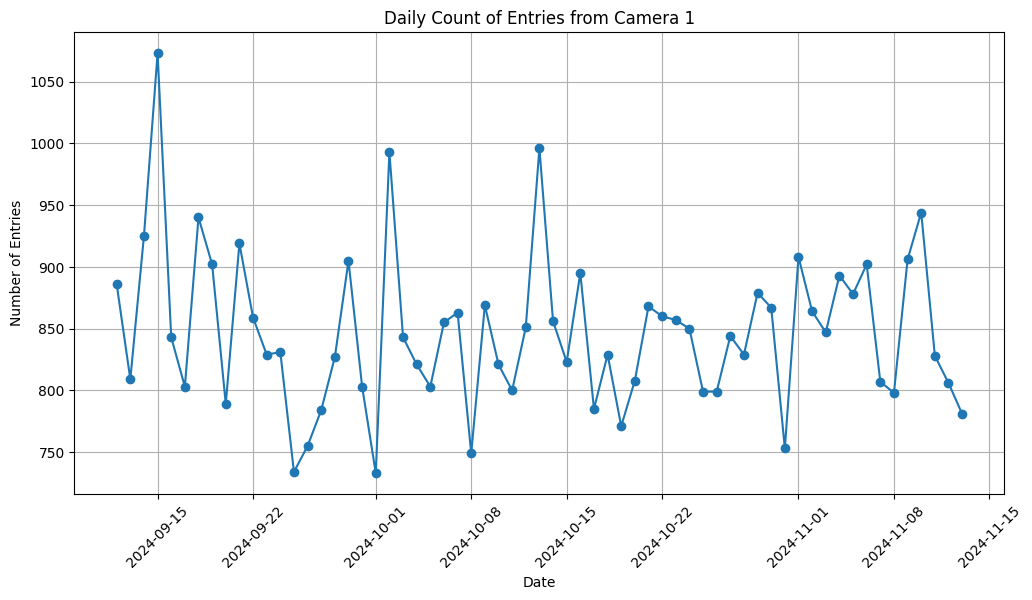

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/parkingLot.csv'
df = pd.read_csv(file_path)

# Process the timestamp and filter data
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df = df.between_time('05:00', '23:59')
df = df.reset_index()
df = df[df['camera_id'] == 1]
df = df.drop(columns=['camera_id'])
df = df.set_index('timestamp')

# Group by day and count entries
df_daily_count = df.resample('D').size().reset_index(name='count')

# Plotting the daily entry counts
plt.figure(figsize=(12, 6))
plt.plot(df_daily_count['timestamp'], df_daily_count['count'], marker='o', linestyle='-')
plt.title("Daily Count of Entries from Camera 1")
plt.xlabel("Date")
plt.ylabel("Number of Entries")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
df_daily_count.head()

,timestamp,count
0,2024-09-12,886
1,2024-09-13,809
2,2024-09-14,925
3,2024-09-15,1073
4,2024-09-16,843


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Like


Best Model: SARIMAX(p=0, q=1)
Mean Absolute Error: 39.62
Mean Absolute Percentage Error: 4.70%
Mean Absolute Scaled Error: 0.58

Actual vs Predicted Values:
Actual: 807, Predicted: 832.5978089194449
Actual: 798, Predicted: 812.0249679673573
Actual: 906, Predicted: 865.5594733824528
Actual: 944, Predicted: 877.8803814221285
Actual: 828, Predicted: 839.7097970317869
Actual: 806, Predicted: 854.7993180555176
Actual: 781, Predicted: 851.6341855814285


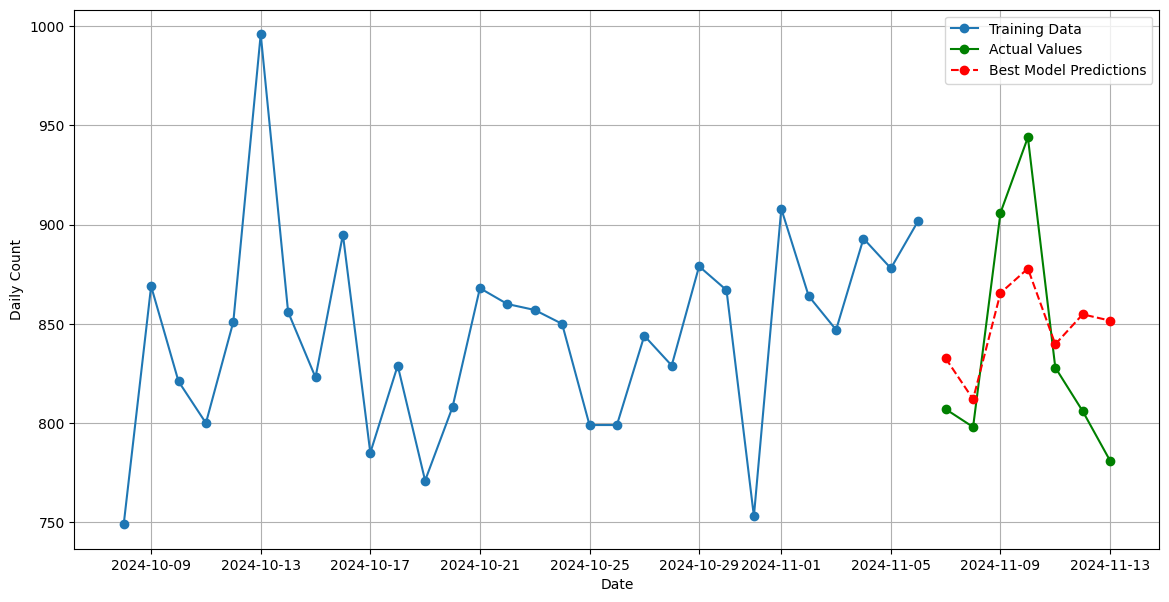

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

def prepare_time_features(data):
    # adding features to account for the weekend
    df = data.copy()
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
    return df

def mase(y_true, y_pred, y_train):
    """ Function to calculate Mean Absolute Scaled Error (MASE)."""
    n = len(y_true)
    d = np.mean(np.abs(np.diff(y_train)))
    errors = np.mean(np.abs(y_true - y_pred))
    return errors / d

def train_and_forecast_sarimax(df_daily_count, test_size=7, plot_history=30, max_p=5, max_q=5):
    """Training the ARIMA model accountinf for seasonality"""

    # Split the data
    train_data = df_daily_count[:-test_size].copy()
    test_data = df_daily_count[-test_size:].copy()

    # Prepare features
    train_data = prepare_time_features(train_data)
    test_data = prepare_time_features(test_data)

    best_model = None
    best_mae = float('inf')
    best_mape = float('inf')
    best_mase = float('inf')
    best_p, best_q = 0, 0

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = SARIMAX(
                    train_data['count'],
                    order=(p, 1, q),
                    seasonal_order=(0, 0, 0, 0),
                    exog=train_data[['is_weekend', 'day_sin', 'day_cos']]
                )
                model_fit = model.fit(disp=False)

                forecast = model_fit.forecast(steps=test_size, exog=test_data[['is_weekend', 'day_sin', 'day_cos']])

                actual_values = test_data['count'].values
                mae = mean_absolute_error(actual_values, forecast)
                mape = np.mean(np.abs((actual_values - forecast) / actual_values)) * 100
                calculated_mase = mase(actual_values, forecast, train_data['count'].values)

                # Check if this model is the best one
                if mae < best_mae:
                    best_model = model_fit
                    best_mae = mae
                    best_mape = mape
                    best_mase = calculated_mase
                    best_p, best_q = p, q

            except Exception as e:
                print(f"Model with p={p}, q={q} failed: {e}")
                continue

    print(f"\nBest Model: SARIMAX(p={best_p}, q={best_q})")
    print(f"Mean Absolute Error: {best_mae:.2f}")
    print(f"Mean Absolute Percentage Error: {best_mape:.2f}%")
    print(f"Mean Absolute Scaled Error: {best_mase:.2f}")

    # Forecast using the best model
    best_forecast = best_model.forecast(steps=test_size, exog=test_data[['is_weekend', 'day_sin', 'day_cos']])

    # Print actual vs predicted values
    print("\nActual vs Predicted Values:")
    for actual, predicted in zip(test_data['count'].values, best_forecast):
        print(f"Actual: {actual}, Predicted: {predicted}")

    # Visualization
    plt.figure(figsize=(14, 7))
    plt.plot(train_data['timestamp'].iloc[-plot_history:], train_data['count'].iloc[-plot_history:], label='Training Data', marker='o')
    plt.plot(test_data['timestamp'], test_data['count'], label='Actual Values', marker='o', color='green')
    plt.plot(test_data['timestamp'], best_forecast, label='Best Model Predictions', marker='o', color='red', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Daily Count')
    plt.legend()
    plt.grid()
    plt.show()

    return best_model

model = train_and_forecast_sarimax(df_daily_count)
